# Hike Planning Grover


In [44]:
import numpy as np
import copy

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
# from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import (
    CplexOptimizer,
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
    GroverOptimizer
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.opflow import PauliExpectation, StateFn, CircuitSampler

In [45]:
def create_problem(mu: np.array, sigma: np.array, total: int = 3) -> QuadraticProgram:
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [mdl.binary_var("x%s" % i) for i in range(len(sigma))]

    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    objective += mdl.sum(
        [sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))]
    )
    mdl.minimize(objective)
#     cost = mdl.sum(x)
#     mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp


def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

In [103]:
#h = np.array([396, 752, 1204, 1177])
#d = np.array([1040, 2480, 7960, 3230])
#T = 5
#M = 1000.0

h = np.array([870, 2501, 4478, 1777, 2970])
d = np.array([2700, 6500, 15000, 100, 10000])
T = 13.5
M = 1000

t = h/(M/2.0) + d/(5.0*M)
print(t)
Q = np.outer(t, t)
print(Q)
b = -2.0 * T * t
# print(b)
# Q = Q + np.diag(b)
# print(Q)

[ 2.28   6.302 11.956  3.574  7.94 ]
[[  5.1984    14.36856   27.25968    8.14872   18.1032  ]
 [ 14.36856   39.715204  75.346712  22.523348  50.03788 ]
 [ 27.25968   75.346712 142.945936  42.730744  94.93064 ]
 [  8.14872   22.523348  42.730744  12.773476  28.37756 ]
 [ 18.1032    50.03788   94.93064   28.37756   63.0436  ]]


In [104]:
import itertools

values = []
print("x, cost")
for x in itertools.product([0, 1], repeat=t.size):
    values.append((x, (T-np.asarray(x).dot(t))**2))
    print(*values[-1])

optimal = min(values, key=lambda value: value[1])
print("Optimal solution:", *optimal)

x, cost
(0, 0, 0, 0, 0) 182.25
(0, 0, 0, 0, 1) 30.913599999999995
(0, 0, 0, 1, 0) 98.525476
(0, 0, 0, 1, 1) 3.9441960000000025
(0, 0, 1, 0, 0) 2.3839360000000016
(0, 0, 1, 0, 1) 40.90881600000001
(0, 0, 1, 1, 0) 4.120899999999997
(0, 0, 1, 1, 1) 99.40089999999998
(0, 1, 0, 0, 0) 51.811204000000004
(0, 1, 0, 0, 1) 0.5505640000000013
(0, 1, 0, 1, 0) 13.133376000000004
(0, 1, 0, 1, 1) 18.62785599999999
(0, 1, 1, 0, 0) 22.63856399999999
(0, 1, 1, 0, 1) 161.239204
(0, 1, 1, 1, 0) 69.42222400000001
(0, 1, 1, 1, 1) 264.77798400000006
(1, 0, 0, 0, 0) 125.88839999999998
(1, 0, 0, 0, 1) 10.758399999999996
(1, 0, 0, 1, 0) 58.461316
(1, 0, 0, 1, 1) 0.08643600000000029
(1, 0, 1, 0, 0) 0.541696000000001
(1, 0, 1, 0, 1) 75.27297600000003
(1, 0, 1, 1, 0) 18.576100000000018
(1, 0, 1, 1, 1) 150.06250000000009
(1, 1, 0, 0, 0) 24.18672399999999
(1, 1, 0, 0, 1) 9.132484000000012
(1, 1, 0, 1, 0) 1.8063359999999984
(1, 1, 0, 1, 1) 43.507216
(1, 1, 1, 0, 0) 49.533444
(1, 1, 1, 0, 1) 224.34048400000003
(1, 1, 

In [105]:
qubo = create_problem(b, Q)
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model4

Minimize
 obj: - 61.560000000000 x0 - 170.154000000000 x1 - 322.812000000000 x2
      - 96.498000000000 x3 - 214.380000000000 x4 + [ 10.396800000000 x0^2
      + 57.474240000000 x0*x1 + 109.038720000000 x0*x2 + 32.594880000000 x0*x3
      + 72.412800000000 x0*x4 + 79.430408000000 x1^2 + 301.386848000000 x1*x2
      + 90.093392000000 x1*x3 + 200.151520000000 x1*x4 + 285.891872000000 x2^2
      + 170.922976000000 x2*x3 + 379.722560000000 x2*x4 + 25.546952000000 x3^2
      + 113.510240000000 x3*x4 + 126.087200000000 x4^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End

## A. Constructing the Ising Hamiltonian

Math! No tips here.

In [106]:
H, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(H)

offset: -109.95016999999996
operator:
-20.056439999999995 * ZIIII
- 9.027923999999999 * IZIII
+ 14.18878 * ZZIII
- 30.20085599999999 * IIZII
+ 47.46532 * ZIZII
+ 21.365371999999997 * IZZII
- 15.918851999999994 * IIIZI
+ 25.01894 * ZIIZI
+ 11.261674 * IZIZI
+ 37.673356 * IIZZI
- 5.759280000000004 * IIIIZ
+ 9.051600000000002 * ZIIIZ
+ 4.07436 * IZIIZ
+ 13.629840000000002 * IIZIZ
+ 7.18428 * IIIZZ


In [107]:
H.to_matrix()

array([[109.95017 +0.j,   0.      +0.j,   0.      +0.j, ...,
          0.      +0.j,   0.      +0.j,   0.      +0.j],
       [  0.      +0.j,  53.58857 +0.j,   0.      +0.j, ...,
          0.      +0.j,   0.      +0.j,   0.      +0.j],
       [  0.      +0.j,   0.      +0.j, -20.488626+0.j, ...,
          0.      +0.j,   0.      +0.j,   0.      +0.j],
       ...,
       [  0.      +0.j,   0.      +0.j,   0.      +0.j, ...,
         77.76267 +0.j,   0.      +0.j,   0.      +0.j],
       [  0.      +0.j,   0.      +0.j,   0.      +0.j, ...,
          0.      +0.j, 192.478154+0.j,   0.      +0.j],
       [  0.      +0.j,   0.      +0.j,   0.      +0.j, ...,
          0.      +0.j,   0.      +0.j, 271.876874+0.j]])

In [108]:
exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H)
exact.eigenstate

VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False)

In [109]:
statevector = exact.eigenstate.primitive
print("Optimal state from Hamiltonian:")
print(statevector.probabilities_dict())
print("Value:")
print(-exact.eigenvalue)

print("\nCompare to orignal solution:")
print(optimal)

Optimal state from Hamiltonian:
{'11001': 1.0}
Value:
(72.21339399999997-0j)

Compare to orignal solution:
((1, 0, 0, 1, 1), 0.08643600000000029)


## B. Finding the minimum

### Evaluating the cost function

First, construct the QAOA ansatz and then write a function to evaluate the energy. Given a quantum circuit, you can evaluate the expectation value as

In [169]:
from qiskit.circuit.library import QAOAAnsatz, GroverOperator, RealAmplitudes


# Real Amplitude
ra = RealAmplitudes(5, reps=3, entanglement='circular', insert_barriers=True)
ra.decompose().draw()

┌──────────┐ ░ ┌───┐                     ░ ┌──────────┐ ░ ┌───┐          »
q_0: ┤ Ry(θ[0]) ├─░─┤ X ├──■──────────────────░─┤ Ry(θ[5]) ├─░─┤ X ├──■───────»
     ├──────────┤ ░ └─┬─┘┌─┴─┐                ░ ├──────────┤ ░ └─┬─┘┌─┴─┐     »
q_1: ┤ Ry(θ[1]) ├─░───┼──┤ X ├──■─────────────░─┤ Ry(θ[6]) ├─░───┼──┤ X ├──■──»
     ├──────────┤ ░   │  └───┘┌─┴─┐           ░ ├──────────┤ ░   │  └───┘┌─┴─┐»
q_2: ┤ Ry(θ[2]) ├─░───┼───────┤ X ├──■────────░─┤ Ry(θ[7]) ├─░───┼───────┤ X ├»
     ├──────────┤ ░   │       └───┘┌─┴─┐      ░ ├──────────┤ ░   │       └───┘»
q_3: ┤ Ry(θ[3]) ├─░───┼────────────┤ X ├──■───░─┤ Ry(θ[8]) ├─░───┼────────────»
     ├──────────┤ ░   │            └───┘┌─┴─┐ ░ ├──────────┤ ░   │            »
q_4: ┤ Ry(θ[4]) ├─░───■─────────────────┤ X ├─░─┤ Ry(θ[9]) ├─░───■────────────»
     └──────────┘ ░                     └───┘ ░ └──────────┘ ░                »
«                ░ ┌───────────┐ ░ ┌───┐                     ░ ┌───────────┐
«q_0: ───────────░─┤ Ry(θ[10]) ├─░─┤ X ├──■──────────────────░─┤ Ry(θ[15]) ├
«                ░ ├───────────┤ ░ └─┬─┘┌─┴─┐                ░ ├───────────┤
«q_1: ───────────░─┤ Ry(θ[11]) ├─░───┼──┤ X ├──■─────────────░─┤ Ry(θ[16]) ├
«                ░ ├───────────┤ ░   │  └───┘┌─┴─┐           ░ ├───────────┤
«q_2: ──■────────░─┤ Ry(θ[12]) ├─░───┼───────┤ X ├──■────────░─┤ Ry(θ[17]) ├
«     ┌─┴─┐      ░ ├───────────┤ ░   │       └───┘┌─┴─┐      ░ ├───────────┤
«q_3: ┤ X ├──■───░─┤ Ry(θ[13]) ├─░───┼────────────┤ X ├──■───░─┤ Ry(θ[18]) ├
«     └───┘┌─┴─┐ ░ ├───────────┤ ░   │            └───┘┌─┴─┐ ░ ├───────────┤
«q_4: ─────┤ X ├─░─┤ Ry(θ[14]) ├─░───■─────────────────┤ X ├─░─┤ Ry(θ[19]) ├
«          └───┘ ░ └───────────┘ ░                     └───┘ ░ └───────────┘

In [160]:
ra.depth()

1

In [167]:
from qiskit.test.mock import FakeQuito
backend=FakeQuito()
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

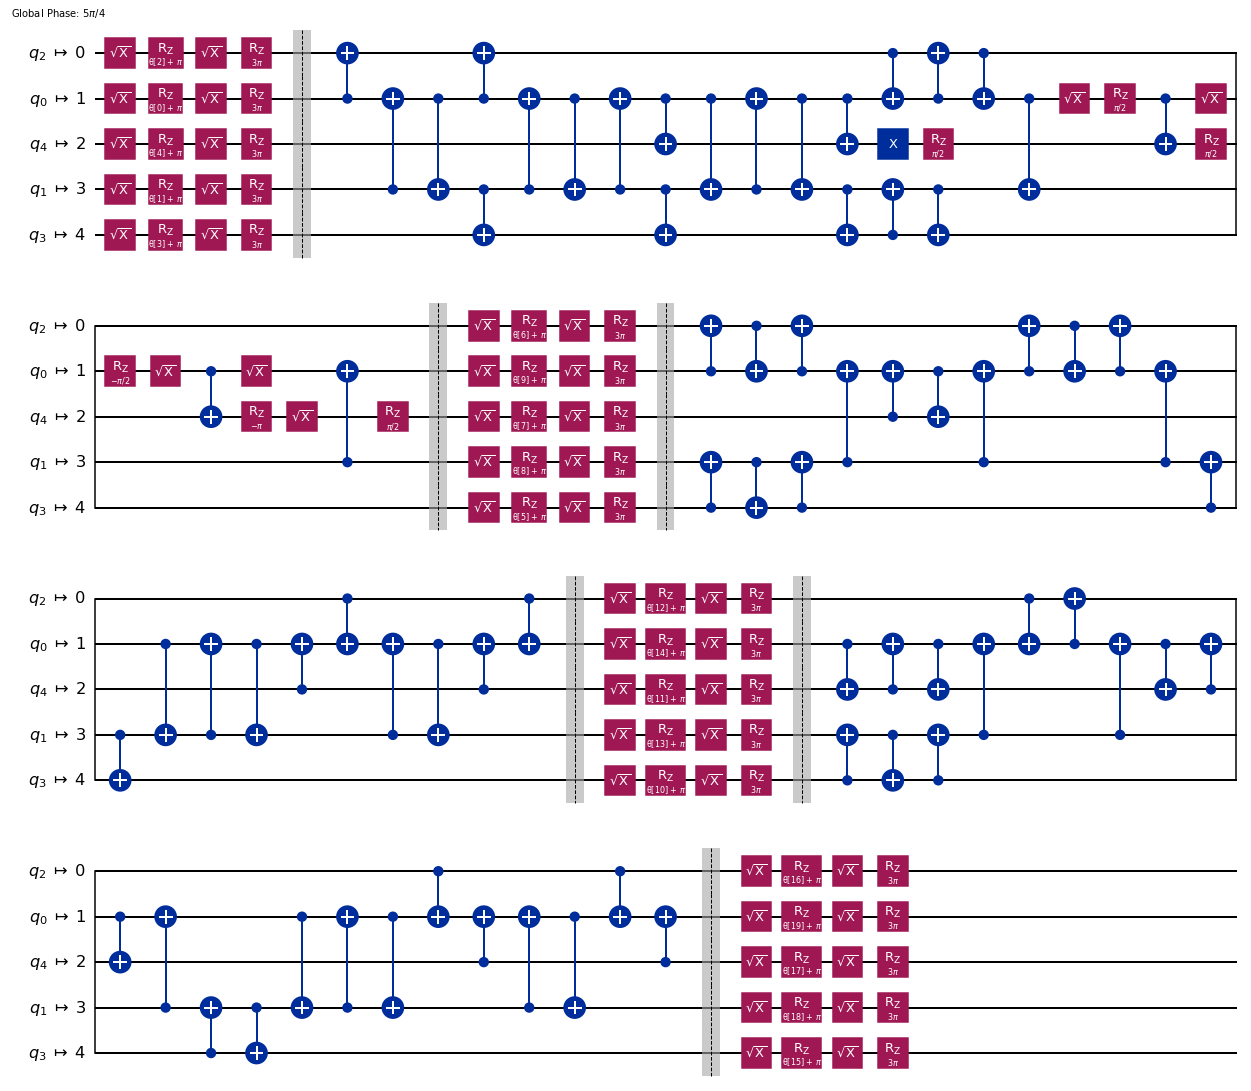

In [168]:
from qiskit import transpile
transpiled = ra.decompose().decompose().decompose()
#transpile(qaoa, basis_gates=["h", "rx", "rz", "rzz"]).draw("mpl", style="iqx")
transpile(transpiled, backend, optimization_level=3).draw("mpl", style="iqx")

In [166]:
transpiled.count_ops()

OrderedDict([('cx', 30), ('u3', 20), ('barrier', 6)])

In [95]:
def exact_energy(theta):
    bound = ra.bind_parameters(theta)
    return np.real(Statevector(bound).expectation_value(H.primitive))

In [94]:
exact_energy(np.array([1,1,1]))

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

### Optimize the energy

Now optimize the energy. You could for instance use one of Qiskit's built-in optimizers as

In [164]:
from qiskit.algorithms.optimizers import L_BFGS_B

optimizer = L_BFGS_B()
initial_parameters = np.random.random(ra.num_parameters)
result = optimizer.minimize(exact_energy, initial_parameters)

result.nfev

1008

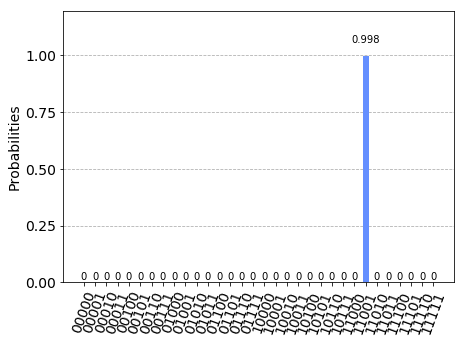

In [165]:
final_state = Statevector(ra.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

In [113]:
probabilities

{'00000': 1.3025188269733464e-08,
 '00001': 1.0425744723515232e-06,
 '00010': 6.818646667316717e-10,
 '00011': 1.284951705646003e-08,
 '00100': 0.001965357738546739,
 '00101': 0.43315482091221447,
 '00110': 1.7998447038938937e-07,
 '00111': 2.3635123217453188e-05,
 '01000': 6.360923189184658e-08,
 '01001': 3.733784647678018e-08,
 '01010': 3.6020951151198835e-06,
 '01011': 7.244139630746113e-06,
 '01100': 6.2243574209362765e-06,
 '01101': 1.7259838180862264e-05,
 '01110': 1.3198436346852748e-06,
 '01111': 7.212148608373763e-07,
 '10000': 1.1180051407264123e-05,
 '10001': 2.5565092769623262e-05,
 '10010': 0.00011380372919340941,
 '10011': 1.3455804629204002e-05,
 '10100': 1.987787291460308e-06,
 '10101': 1.4433661861654075e-07,
 '10110': 4.381308332341634e-07,
 '10111': 5.9206096571131695e-09,
 '11000': 0.002552694404181867,
 '11001': 0.5620056606119458,
 '11010': 1.9353860306758777e-06,
 '11011': 8.940076248051325e-05,
 '11100': 8.155772530733124e-11,
 '11101': 2.1921833522613695e-06,
 

# The rest is not yet runnable

In [20]:
betas = gammas = np.linspace(-np.pi, np.pi, 100)
landscape = [[exact_energy([beta, gamma]) for beta in betas] for gamma in gammas]

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

In [ ]:
import matplotlib.pyplot as plt

X, Y = np.meshgrid(betas, gammas)
plt.figure(figsize=(12, 6))
plt.contourf(X, Y, landscape)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.colorbar()

In [ ]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=100)

initial_parameters = np.arange(6)
result = optimizer.minimize(exact_energy, initial_parameters)

In [18]:
print(result)

{   'fun': -6.2100421455814505,
    'jac': None,
    'nfev': 644,
    'nit': 92,
    'njev': 92,
    'x': array([0.45459506, 0.84630319, 0.54016906, 0.83336851, 0.474771  ,
       0.72325817])}


In [19]:
X, Y = np.meshgrid(betas, gammas)
plt.figure(figsize=(12, 6))
plt.contourf(X, Y, landscape)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.scatter(result.x[0], result.x[1], s=100, color="crimson")
plt.colorbar()

NameError: name 'plt' is not defined

In [28]:
print("Number of circuit executions:", result.nfev)

Number of circuit executions: 200


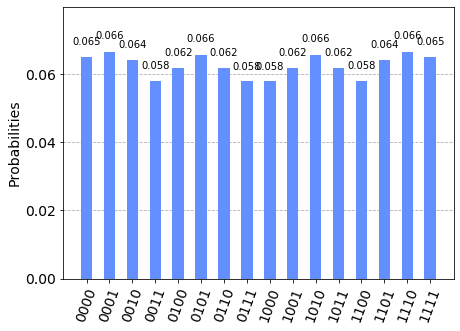

In [29]:
from qiskit.visualization import plot_histogram

final_state = Statevector(qaoa.bind_parameters(result.x))
probabilities = final_state.probabilities_dict()

plot_histogram(probabilities)

In [413]:
from qiskit.algorithms.optimizers import COBYLA

def example_function(x):
    return (np.linalg.norm(x) - 1) ** 2

example_x0 = np.array([1, 1])  # initial point

example_result = COBYLA().minimize(example_function, example_x0)

print("Minimum at:", example_result.x)
print("Function value:", example_result.fun)

Minimum at: [0.9826468  0.18479216]
Function value: 1.6530767025061928e-08


**Expected result** The optimal solutions should be at least among the 5 most likely states and have a probability distinctively larger than $1 / 2^\text{n}$, where $n$ is the number of qubits.

### Warmstarting

### CVaR expectation

Update your energy evaluation such that only the best $\alpha \in (0, 1]$ fraction of the shots contribute to the expectation value.

## C. Circuit optimization

Now we'll transpile the circuit for the ``ibmq_quito`` device.

In [3]:
from qiskit.test.mock import FakeQuito
backend = FakeQuito()

# or for the actual device, if you have an IBM Quantum Experience account
# from qiskit import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(group="open")
# backend = provider.get_backend("ibmq_quito")

### Pulse efficient decomposition

*Note: This works correctly only for a circuit with bound parameters.*

You can draw a pulse schedule as follows.

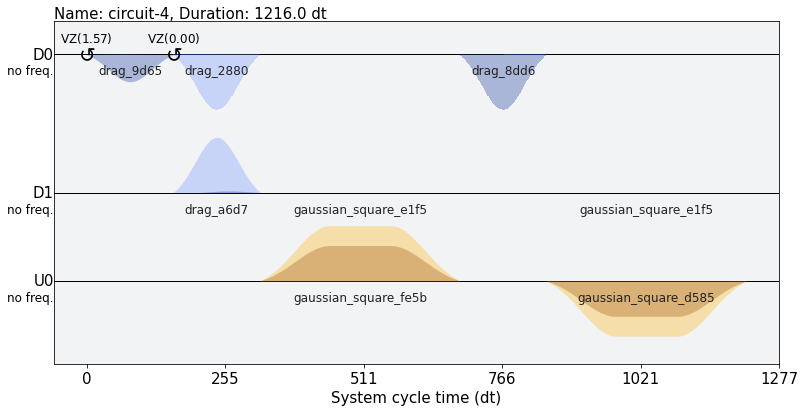

In [4]:
from qiskit import transpile, schedule, QuantumCircuit

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

transpiled = transpile(circuit, backend)

schedule(transpiled, backend).draw()